In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(str("/content/drive/MyDrive/Colab Notebooks"))

In [ ]:
import pandas as pd
import numpy as np
import MLtemplate as ml
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
import pymc3 as pm
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
campaigndf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/marketing_campaign.csv", sep=";")

In [ ]:
campaigndf.head(5)

ID  Year_Birth   Education  ... Z_CostContact  Z_Revenue  Response
0  5524        1957  Graduation  ...             3         11         1
1  2174        1954  Graduation  ...             3         11         0
2  4141        1965  Graduation  ...             3         11         0
3  6182        1984  Graduation  ...             3         11         0
4  5324        1981         PhD  ...             3         11         0

[5 rows x 29 columns]

In [ ]:
ml.missing_values(campaigndf)

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [ ]:
campaigndf = campaigndf[~campaigndf["Income"].isnull()]

In [ ]:
campaigndf["Income"].isnull().sum()

0

In [ ]:
ml.data_summary(campaigndf, 5)

###### Shape ######
(2216, 29)
###### Dimensions ######
2
###### Dtypes ######
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object
###### h

In [ ]:
campaigndf.describe()

ID   Year_Birth  ...  Z_Revenue     Response
count   2216.000000  2216.000000  ...     2216.0  2216.000000
mean    5588.353339  1968.820397  ...       11.0     0.150271
std     3249.376275    11.985554  ...        0.0     0.357417
min        0.000000  1893.000000  ...       11.0     0.000000
25%     2814.750000  1959.000000  ...       11.0     0.000000
50%     5458.500000  1970.000000  ...       11.0     0.000000
75%     8421.750000  1977.000000  ...       11.0     0.000000
max    11191.000000  1996.000000  ...       11.0     1.000000

[8 rows x 26 columns]

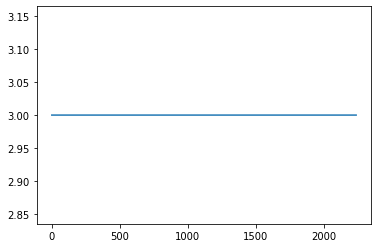

In [ ]:
campaigndf["Z_CostContact"].plot()

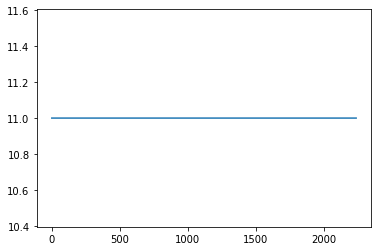

In [ ]:
campaigndf["Z_Revenue"].plot()

drop these two variables

In [ ]:
campaigndf = ml.drop_columns(campaigndf, ["Z_Revenue", "Z_CostContact"])

In [ ]:
numerical_col = ["Kidhome" , "Teenhome", "Income"] + [i for i in campaigndf.columns if i.startswith("Mnt") or i.startswith("Num")]

numerical_col

['Kidhome',
 'Teenhome',
 'Income',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth']

In [ ]:
categ_columns = [ i for i in campaigndf.columns if i not in numerical_col]
categ_columns

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Dt_Customer',
 'Recency',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response']

In [ ]:
campaigndf["Dt_Customer"] = pd.to_datetime(campaigndf["Dt_Customer"])

In [ ]:
print( "oldest_enrollment = " + str( campaigndf["Dt_Customer"].min()))
print( "newest_enrollment = " + str( campaigndf["Dt_Customer"].max()))
enroll_max_date = campaigndf["Dt_Customer"].max()

oldest_enrollment = 2012-07-30 00:00:00
newest_enrollment = 2014-06-29 00:00:00


we will calculate number of days customer is enrolled

In [ ]:
campaigndf["Days_enrolled"] = (enroll_max_date - campaigndf["Dt_Customer"]).dt.days

In [ ]:
campaigndf["Days_enrolled"]

0       663
1       113
2       312
3       139
4       161
       ... 
2235    381
2236     19
2237    155
2238    156
2239    622
Name: Days_enrolled, Length: 2216, dtype: int64

In [ ]:
campaigndf["Dt_Customer"].max().year

2014

calculate customer's age

In [ ]:
campaigndf["Age"] = campaigndf["Dt_Customer"].max().year - campaigndf["Year_Birth"]
campaigndf["Age"]

0       57
1       60
2       49
3       30
4       33
        ..
2235    47
2236    68
2237    33
2238    58
2239    60
Name: Age, Length: 2216, dtype: int64

In [ ]:
campaigndf = ml.drop_columns(campaigndf, ["Dt_Customer", "ID", "Year_Birth"])

In [ ]:
plot_col = ["Age", "Days_enrolled"] + numerical_col

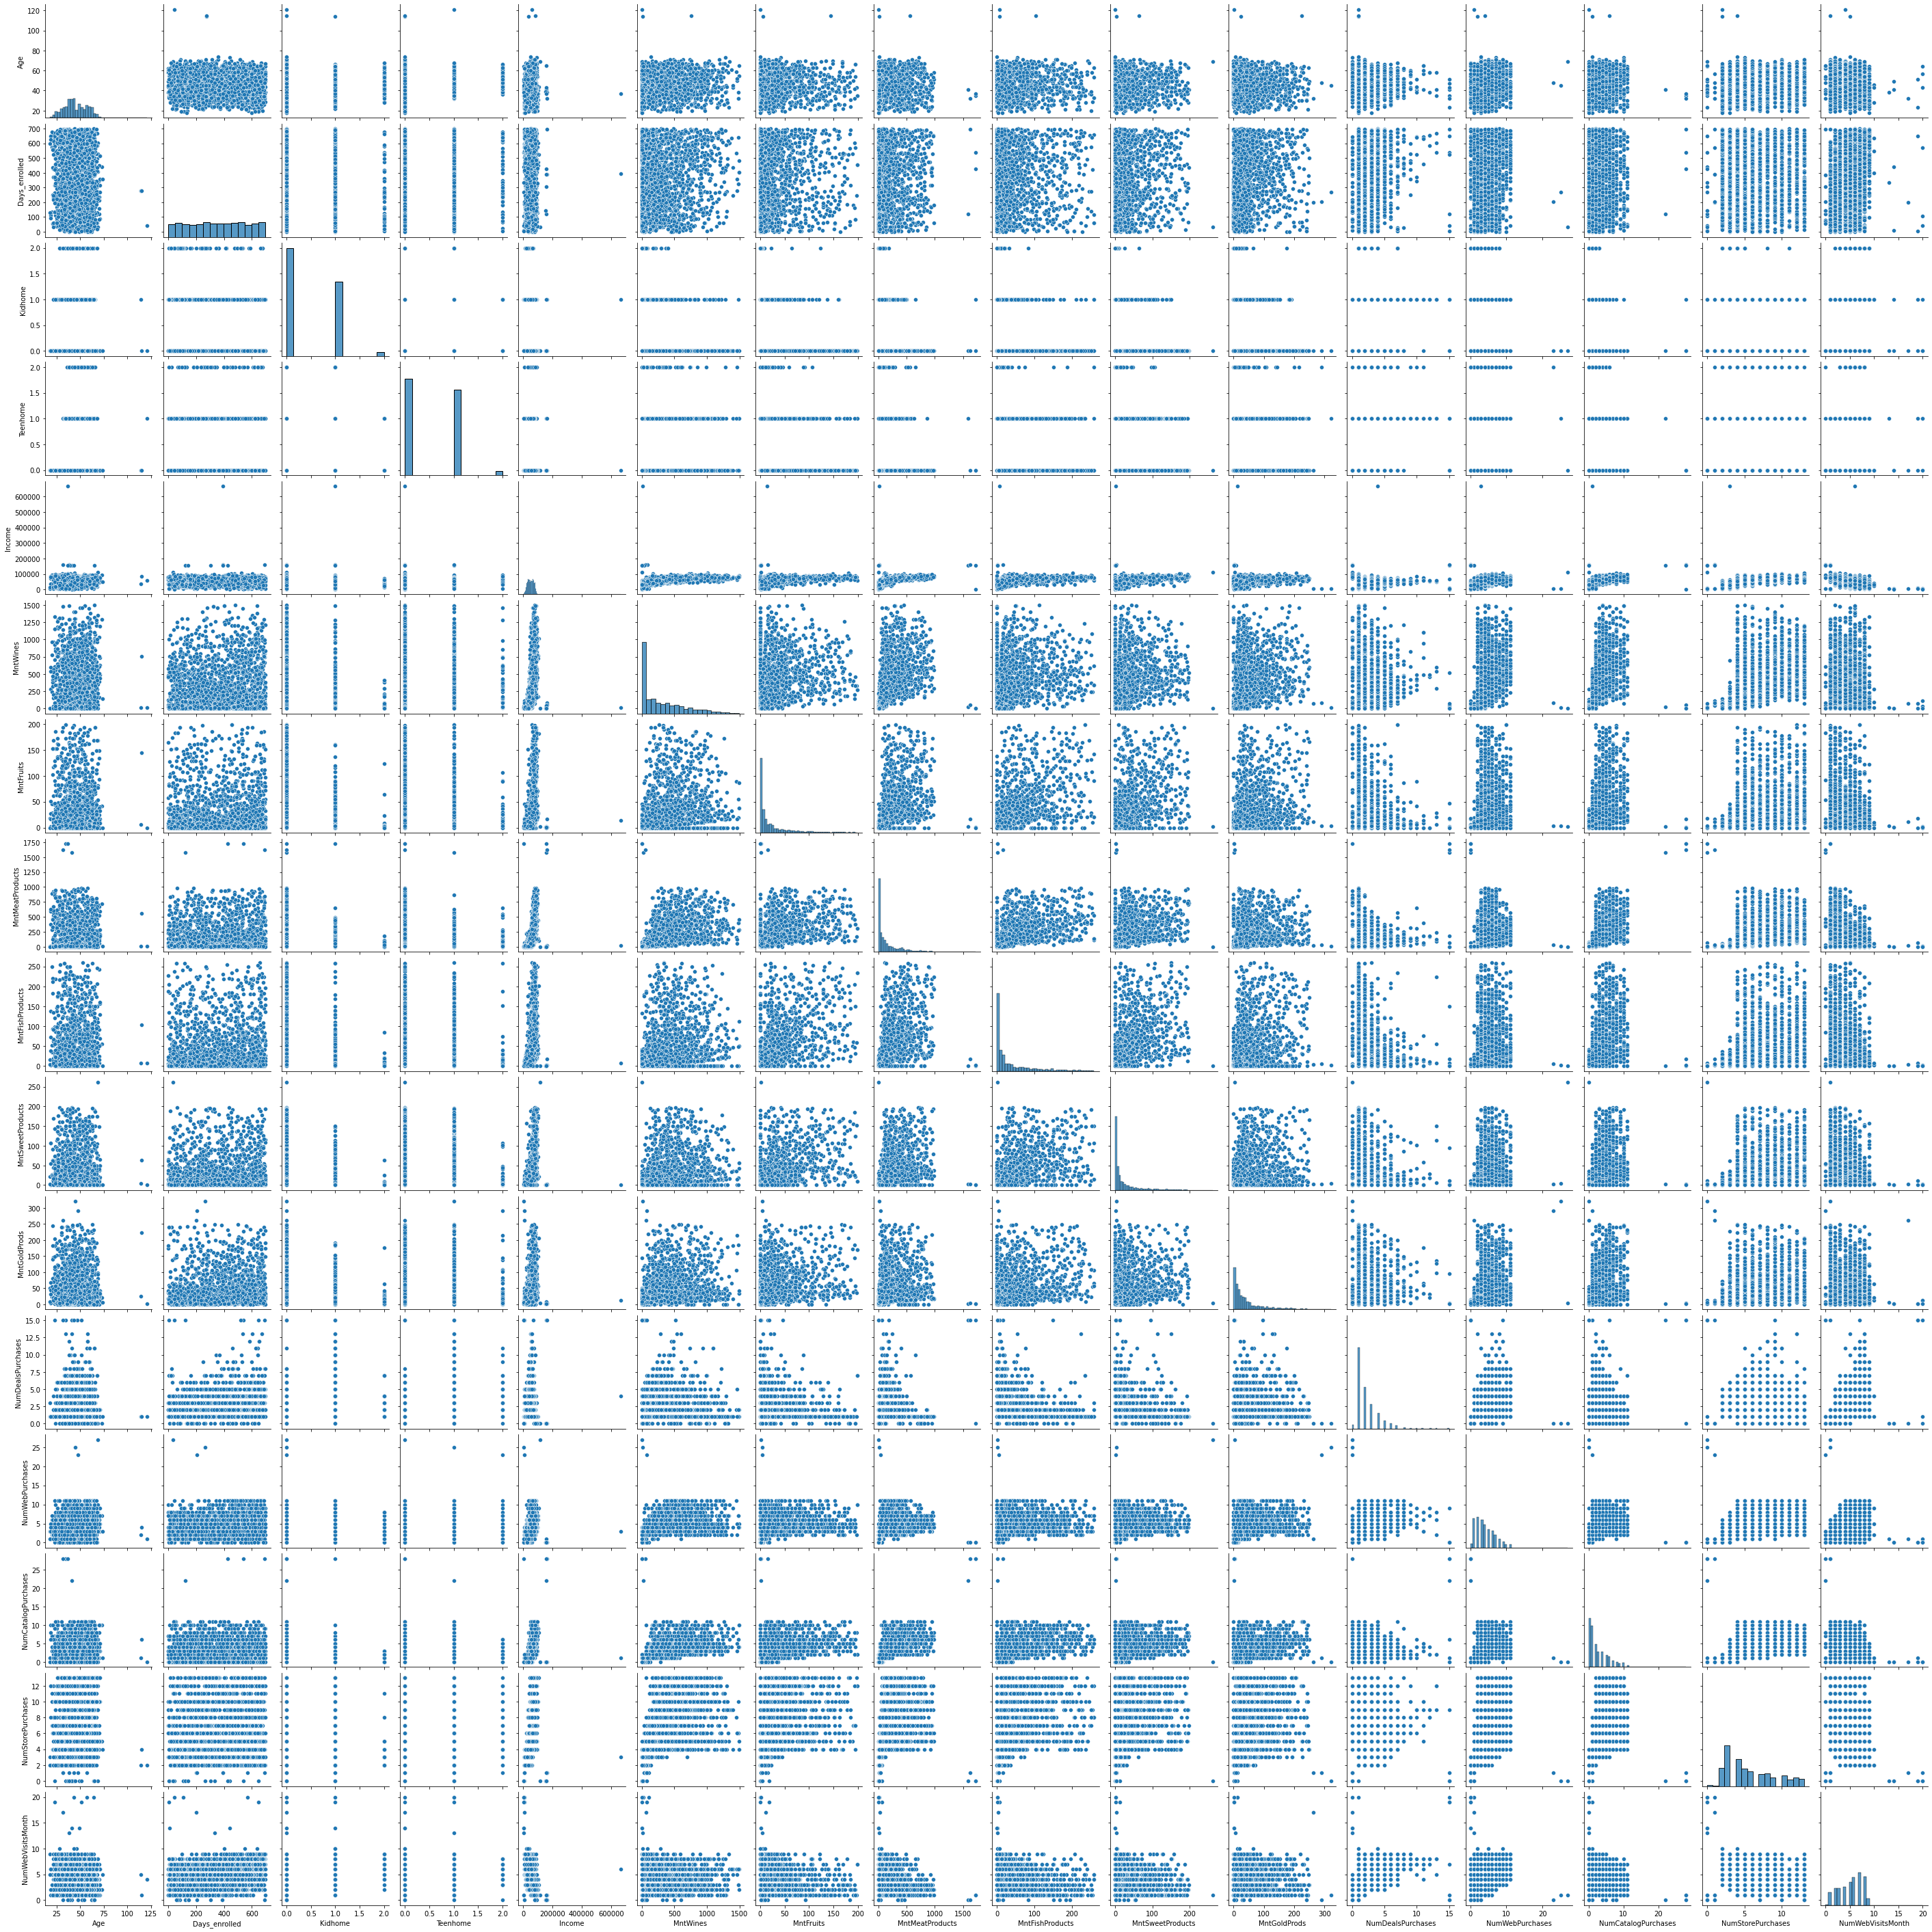

In [ ]:

sns.pairplot(campaigndf[plot_col])

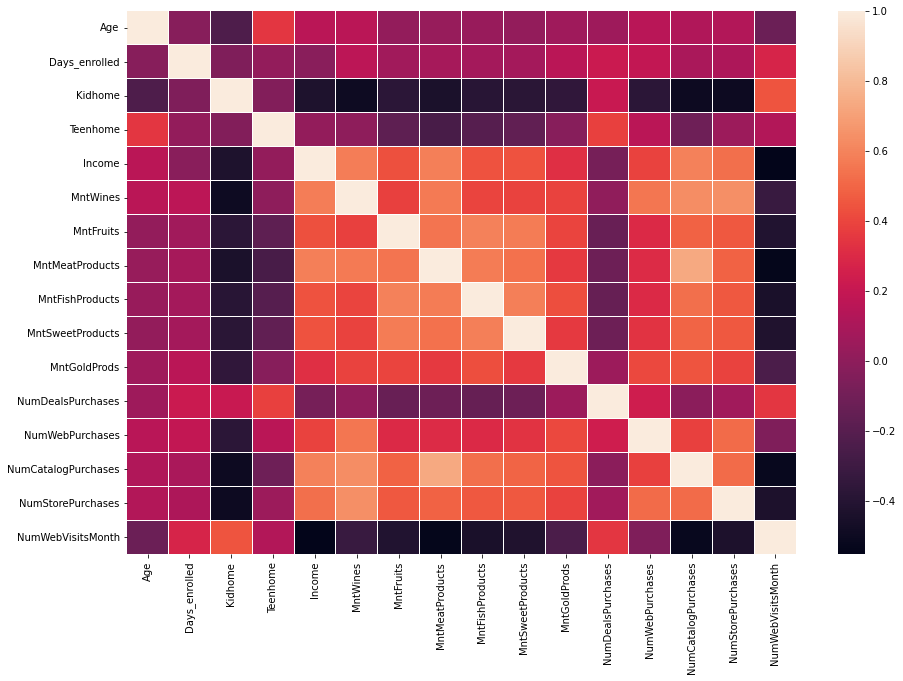

In [ ]:
ml.corr_heatmap(campaigndf[plot_col])

we see there is some positve correlation between income and the amout of different products spent

In [ ]:
campaigndf["AllMnt"] = 0
getMnt = [i for i in campaigndf.columns if i.startswith("Mnt")]
for i in getMnt:
    campaigndf["AllMnt"] = campaigndf["AllMnt"] + campaigndf[i]

In [ ]:
campaigndf[["Income", "AllMnt"]].corr()["Income"]["AllMnt"]

0.6675760903888281

check individual correlation wof amount spent on products with income

In [ ]:
print(getMnt)
for i in getMnt:
    print(campaigndf[["Income", i]].corr()["Income"][i])

['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
0.5786497501367406
0.430841680990874
0.5846333567663221
0.43887135945163813
0.44074379151936843
0.3259164464972657


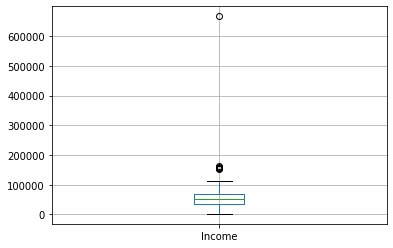

In [ ]:
campaigndf.boxplot( column="Income" , sym='o', return_type='axes')

Lets remove these outliers

In [ ]:
campaigndf["Income"].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

####### histogram ########


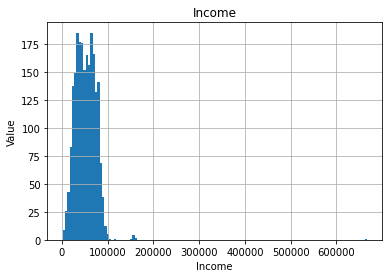

In [ ]:
ml.numerical_analysis(campaigndf,["Income"], plots="histogram")

removing outliers for Income

In [ ]:
_, upper_value = ml.outlier_boundary(campaigndf, "Income")

Lower value = -14525.5
Upper Value = 118350.5


In [ ]:
campaigndf = campaigndf[campaigndf["Income"] < upper_value]

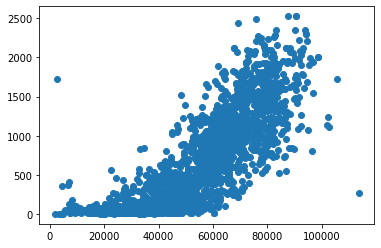

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["AllMnt"])

It seems as income increases spending also increase

In [ ]:
campaigndf[["Income", "AllMnt"]].corr()["Income"]["AllMnt"]

0.823628265993962

This is a very high correlation which means further down we will need to drop the spending on product column

In [ ]:
campaigndf[["Income", "MntWines"]].corr()["Income"]["MntWines"]

0.7304883589907466

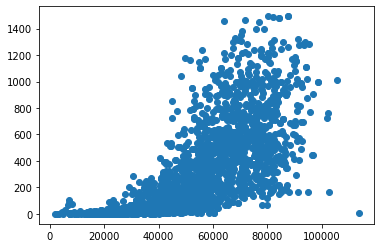

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["MntWines"])

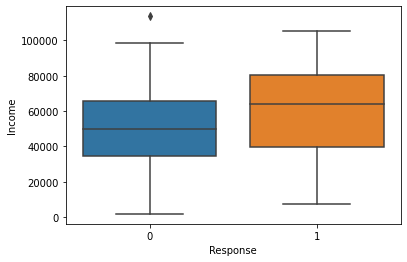

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Income"])

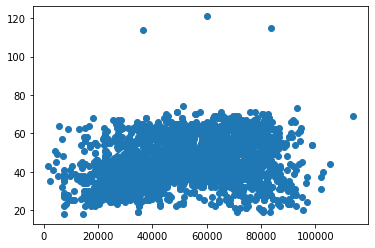

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["Age"])

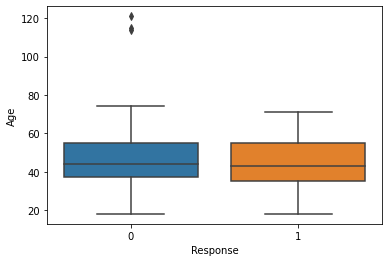

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Age"])

There does not seems to be much difference in the 2 groups fro age, therefore we can discard this column

In [ ]:
campaigndf = ml.drop_columns(campaigndf, "Age")

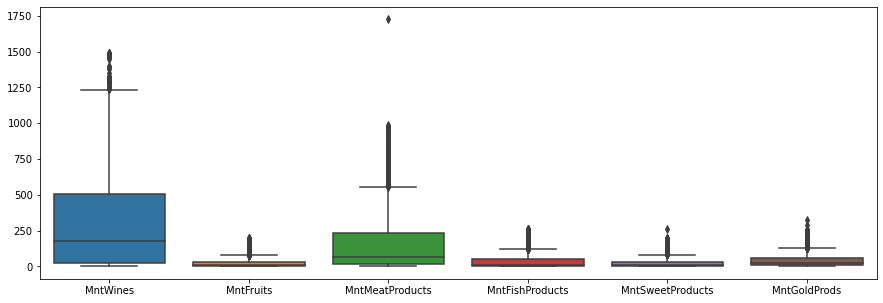

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=campaigndf[getMnt])

from the above plot we see that most of the spending was done wines

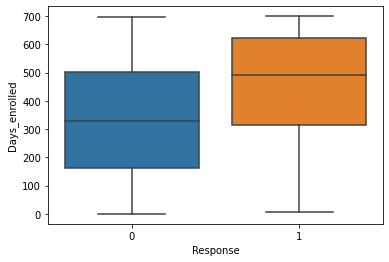

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Days_enrolled"])

### Categorical variables analysis with Target

In [ ]:
def chisquare_test(df, list_of_cols, alpha=0.05):
    contingency = pd.crosstab(index=df[list_of_cols[0]], columns=df[list_of_cols[1]])
    # Chi-square test of independence. 
    c, p, dof, expected = chi2_contingency(contingency) # Print the p-value
    print("P value : " + str(p))
    if p < alpha:
        print("Reject Null Hypothesis")
        print("There is relationship")
    else:
        print("Accept Null Hypothesis")
        print("No relationship")

In [ ]:
chisquare_test(campaigndf, ["Response", "Marital_Status"])

P value : 3.84440744025402e-09
Reject Null Hypothesis
There is relationship


In [ ]:
campaigndf["Response"].value_counts()

0    1875
1     333
Name: Response, dtype: int64

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Marital_Status"], normalize='columns')*100

Marital_Status  Absurd      Alone   Divorced  ...   Together      Widow  YOLO
Response                                      ...                            
0                 50.0  66.666667  79.220779  ...  89.455185  76.315789  50.0
1                 50.0  33.333333  20.779221  ...  10.544815  23.684211  50.0

[2 rows x 8 columns]

In [ ]:
list(pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Marital_Status"], normalize='columns').iloc[0])

[0.5,
 0.6666666666666666,
 0.7922077922077922,
 0.8852459016393442,
 0.7749469214437368,
 0.8945518453427065,
 0.7631578947368421,
 0.5]

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Marital_Status"], normalize='columns').columns

Index(['Absurd', 'Alone', 'Divorced', 'Married', 'Single', 'Together', 'Widow',
       'YOLO'],
      dtype='object', name='Marital_Status')

AttributeError: ignored

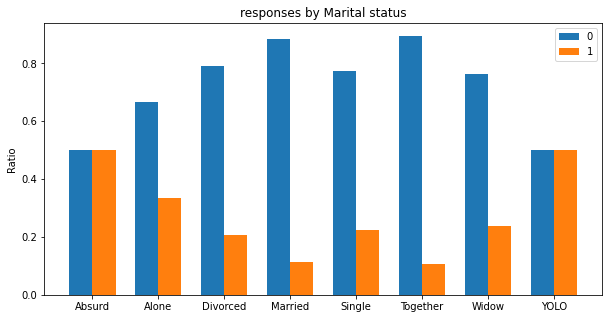

In [ ]:
labels = pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Marital_Status"], normalize='columns').columns
Res_0 = list(pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Marital_Status"], normalize='columns').iloc[0])
Res_1 = list(pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Marital_Status"], normalize='columns').iloc[1])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, Res_0, width, label='0')
rects2 = ax.bar(x + width/2, Res_1, width, label='1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio')
ax.set_title('responses by Marital status')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

based on the above we see that Divorced, Alone, Single, widow are follwing the same pattern. Absurd and YOLO will be dropped as they show no significant difference. Married, Together show same patter. We will merge all the Divorced, Alone, Single, widow into 0 and Married, Together into 1

In [ ]:
campaigndf = ml.drop_rows(campaigndf, "Marital_Status", "Absurd")
campaigndf = ml.drop_rows(campaigndf, "Marital_Status", "YOLO")

In [ ]:
campaigndf["Marital_Status"] = campaigndf["Marital_Status"].replace(["Married", "Together"], 1)
campaigndf["Marital_Status"] = campaigndf["Marital_Status"].replace(["Alone", "Divorced", "Single", "Widow"], 0)

In [ ]:
campaigndf["Marital_Status"].head()

0    0
1    0
2    1
3    1
4    1
Name: Marital_Status, dtype: int64

### Check education

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Education"], normalize='columns')*100

Education  2n Cycle      Basic  Graduation     Master        PhD
Response                                                        
0              89.0  96.296296   86.420863  84.573003  78.947368
1              11.0   3.703704   13.579137  15.426997  21.052632

There seems to be some kind of incresing trend so we will rank these

In [ ]:
campaigndf["Education"] = campaigndf["Education"].replace(["Basic", "2n Cycle", "Graduation", "Master", "PhD"], [1,2,3,4,5])

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["AcceptedCmp1"], normalize="columns")*100

AcceptedCmp1          0          1
Response                          
0             87.736306  44.680851
1             12.263694  55.319149

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["AcceptedCmp2"], normalize="columns")*100

AcceptedCmp2          0          1
Response                          
0             85.694572  33.333333
1             14.305428  66.666667

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["AcceptedCmp3"], normalize="columns")*100

AcceptedCmp3         0          1
Response                         
0             87.55512  52.760736
1             12.44488  47.239264

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["AcceptedCmp4"], normalize="columns")*100

AcceptedCmp4          0          1
Response                          
0             86.813725  62.195122
1             13.186275  37.804878

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["AcceptedCmp5"], normalize="columns")*100

AcceptedCmp5          0          1
Response                          
0             88.203622  44.099379
1             11.796378  55.900621

Based on above we can tell that campaign 2 and 5 were more effective in bringing the response to the recent campaign and others were not. We will combine in a way that 1 represent campaign 2 and 5 and 0 represent campaign 1,3,4

In [ ]:
campaigndf["Acceptcm25"] = 0
campaigndf["Acceptcm25"].loc[campaigndf["AcceptedCmp2"] == 1] = 1
campaigndf["Acceptcm25"].loc[campaigndf["AcceptedCmp5"] == 1] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
campaigndf = ml.drop_columns(campaigndf, ["AcceptedCmp5", "AcceptedCmp4", "AcceptedCmp3", "AcceptedCmp2", "AcceptedCmp1"])

### Check Complain

In [ ]:
pd.crosstab(index=campaigndf["Response"], columns=campaigndf["Complain"], normalize="columns")*100

Complain          0          1
Response                      
0         84.974805  85.714286
1         15.025195  14.285714

In [ ]:
chisquare_test(campaigndf,["Response","Complain" ])

P value : 0.8317352986815836
Accept Null Hypothesis
No relationship


we will drop this column as well

In [ ]:
campaigndf = ml.drop_columns(campaigndf, "Complain")

(array([95., 48., 24., 33., 26., 23., 40., 18., 16.,  8.]),
 array([1.0000e+00, 1.5010e+02, 2.9920e+02, 4.4830e+02, 5.9740e+02,
        7.4650e+02, 8.9560e+02, 1.0447e+03, 1.1938e+03, 1.3429e+03,
        1.4920e+03]),
 <a list of 10 Patch objects>)

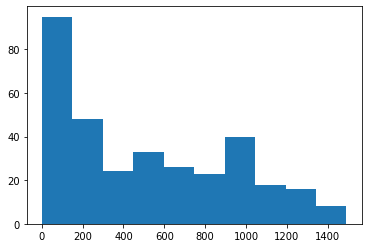

In [ ]:
plt.hist(campaigndf[campaigndf["Response"] == 1]["MntWines"])

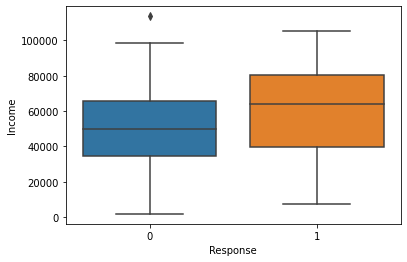

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Income"])

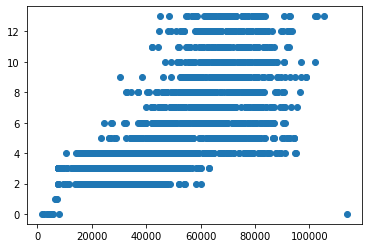

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["NumStorePurchases"])

In [ ]:
campaigndf[["Income", "NumStorePurchases"]].corr()["Income"]["NumStorePurchases"]

0.6861665732007014

In [ ]:
campaigndf= ml.drop_columns(campaigndf, "NumStorePurchases")

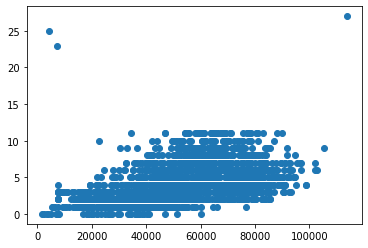

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["NumWebPurchases"])

In [ ]:
campaigndf[["Income", "NumWebPurchases"]].corr()["Income"]["NumWebPurchases"]

0.5034610036607812

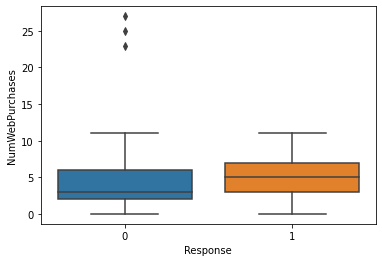

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["NumWebPurchases"])

There does not seem to be much difference therefore we will drop this column as well

In [ ]:
campaigndf = ml.drop_columns(campaigndf, "NumWebPurchases")

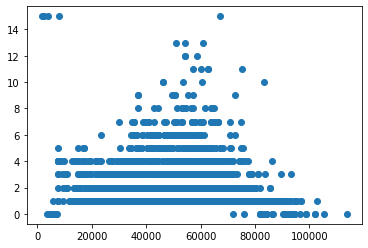

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["NumDealsPurchases"])

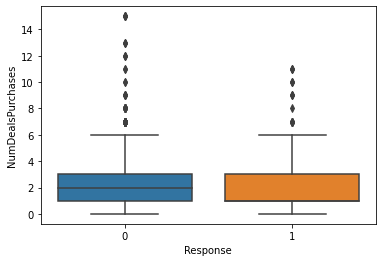

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["NumDealsPurchases"])

In [ ]:
campaigndf[campaigndf["Response"] == 1]["NumDealsPurchases"].describe()

count    331.000000
mean       2.335347
std        2.111854
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       11.000000
Name: NumDealsPurchases, dtype: float64

In [ ]:
campaigndf[campaigndf["Response"] == 0]["NumDealsPurchases"].describe()


count    1873.000000
mean        2.310731
std         1.842801
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64

for now we keep NumDealsPurchases 

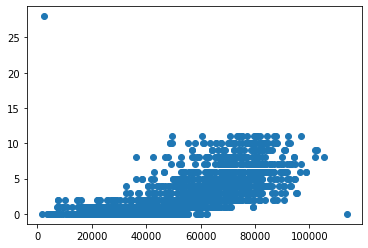

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["NumCatalogPurchases"])

In [ ]:
campaigndf[["Income", "NumCatalogPurchases"]].corr()["Income"]["NumCatalogPurchases"]

0.7097620211307457

We will drop this column as well as it is highly correlated with Income

In [ ]:
campaigndf = ml.drop_columns(campaigndf, "NumCatalogPurchases")

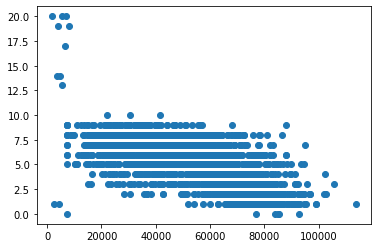

In [ ]:

plt.scatter(campaigndf["Income"], campaigndf["NumWebVisitsMonth"])

In [ ]:
campaigndf[["Income", "NumWebVisitsMonth"]].corr()["Income"]["NumWebVisitsMonth"]

-0.6484343432896718

Drop this as well

In [ ]:
campaigndf = ml.drop_columns(campaigndf,"NumWebVisitsMonth" )

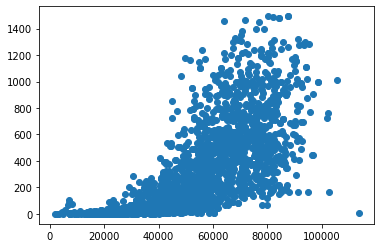

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["MntWines"])

In [ ]:
campaigndf[["Income", "MntWines"]].corr()["Income"]["MntWines"]

0.7306820739875992

In [ ]:
campaigndf = ml.drop_columns(campaigndf, "MntWines")

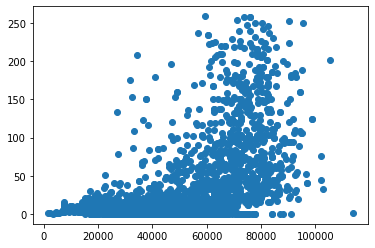

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["MntFishProducts"])

In [ ]:
campaigndf[["Income", "MntFishProducts"]].corr()["Income"]["MntFishProducts"]

0.5518663551248124

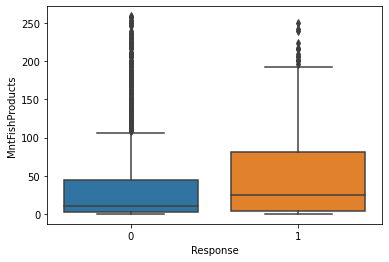

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["MntFishProducts"])

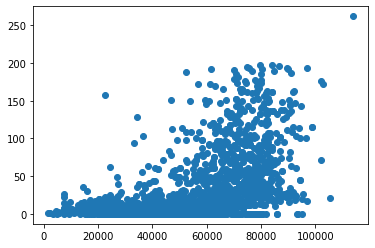

0.5558397384871815

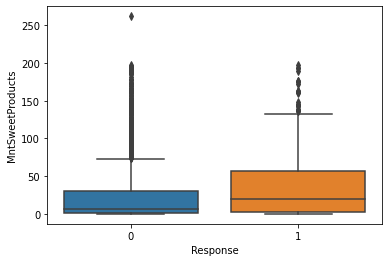

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["MntSweetProducts"])
plt.show()
sns.boxplot(x=campaigndf["Response"],y=campaigndf["MntSweetProducts"])
campaigndf[["Income", "MntSweetProducts"]].corr()["Income"]["MntSweetProducts"]

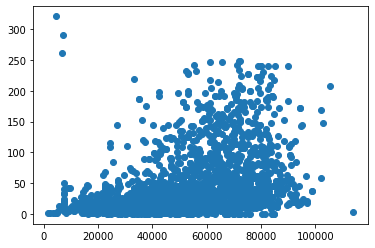

0.41763319766102647

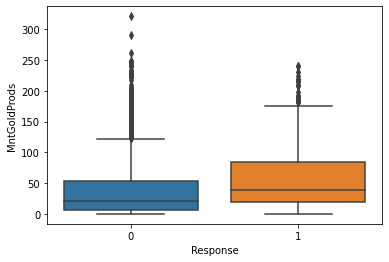

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["MntGoldProds"])
plt.show()
sns.boxplot(x=campaigndf["Response"],y=campaigndf["MntGoldProds"])
campaigndf[["Income", "MntGoldProds"]].corr()["Income"]["MntGoldProds"]

In [ ]:
campaigndf[campaigndf["Response"] == 1]["MntGoldProds"].describe()

count    331.000000
mean      60.755287
std       56.752338
min        0.000000
25%       20.000000
50%       39.000000
75%       83.500000
max      241.000000
Name: MntGoldProds, dtype: float64

In [ ]:
campaigndf[campaigndf["Response"] == 0]["MntGoldProds"].describe()

count    1873.000000
mean       41.001068
std        50.142021
min         0.000000
25%         7.000000
50%        21.000000
75%        53.000000
max       321.000000
Name: MntGoldProds, dtype: float64

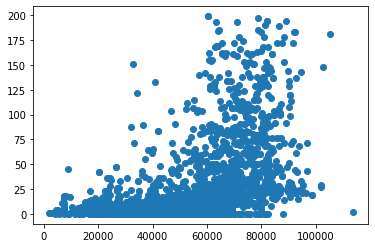

0.537891850497563

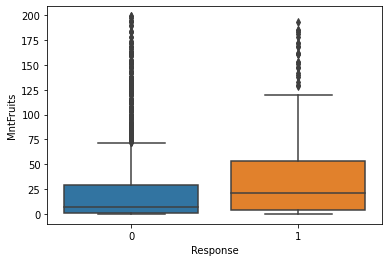

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["MntFruits"])
plt.show()
sns.boxplot(x=campaigndf["Response"],y=campaigndf["MntFruits"])
campaigndf[["Income", "MntFruits"]].corr()["Income"]["MntFruits"]

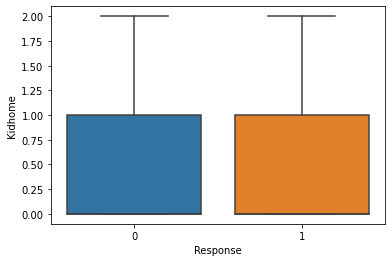

In [ ]:
# plt.scatter(campaigndf["Income"], campaigndf["MntFruits"])
# plt.show()
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Kidhome"])
# campaigndf[["Income", "MntFruits"]].corr()["Income"]["MntFruits"]

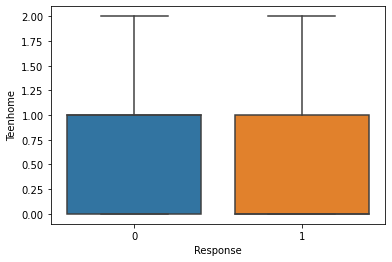

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Teenhome"])

It seems number of kids and teens are not giving any fruitful information therefore we will dop these columns

In [ ]:
campaigndf = ml.drop_columns(campaigndf, ["Kidhome", "Teenhome"])

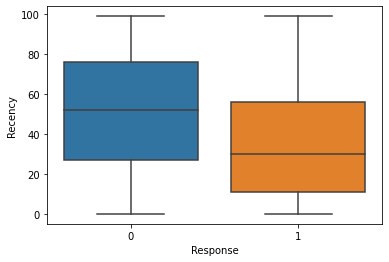

In [ ]:
sns.boxplot(x=campaigndf["Response"],y=campaigndf["Recency"])

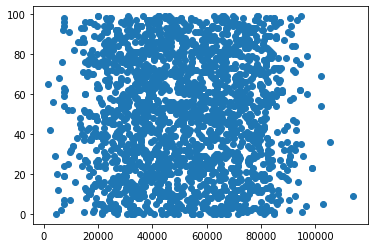

In [ ]:
plt.scatter(campaigndf["Income"], campaigndf["Recency"])

(array([230., 219., 232., 211., 213., 230., 211., 223., 221., 214.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

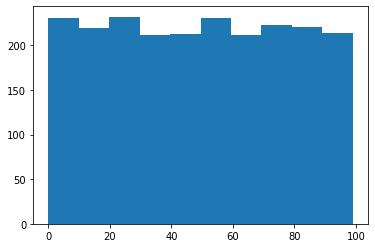

In [ ]:
plt.hist(campaigndf["Recency"])

In [ ]:
campaigndf = ml.drop_columns(campaigndf, ["AllMnt"])

In [ ]:
campaigndf.head()

Education  Marital_Status   Income  ...  Response  Days_enrolled  Acceptcm25
0          3               0  58138.0  ...         1            663           0
1          3               0  46344.0  ...         0            113           0
2          3               1  71613.0  ...         0            312           0
3          3               1  26646.0  ...         0            139           0
4          5               1  58293.0  ...         0            161           0

[5 rows x 13 columns]

In [ ]:
y = campaigndf["Response"]
X = campaigndf.drop("Response", axis=1)

In [ ]:
 feature_values = ml.RFfeatureimportance(campaigndf, X, y)
 feature_values

Recency              0.137542
Days_enrolled        0.129530
Income               0.125531
MntMeatProducts      0.117082
MntGoldProds         0.090986
MntFishProducts      0.074922
MntSweetProducts     0.071885
Acceptcm25           0.067220
MntFruits            0.064704
NumDealsPurchases    0.047729
Education            0.041925
Marital_Status       0.030944
dtype: float64

In [ ]:
feature_values.index[:3]

Index(['Recency', 'Days_enrolled', 'Income'], dtype='object')

In [ ]:
X = X[feature_values.index[:3]]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(predictors, labels, test_size=0.20)
trainx, testx, trainy, testy = ml.train_test(campaigndf,X[feature_values.index[:3]],y,standard_scaling=True)
new_trainx, new_trainy = ml.address_class_imbalance(trainx,trainy,"SMOTE")
clf = LogisticRegression()
clf.fit(new_trainx, new_trainy)
y_pred = clf.predict(testx)
ml.validatemetrics_class(y_pred, testy, "Logistic Regression")

{'accuracy': 0.691609977324263,
 'auc_val': 0.7010802469135803,
 'f_score': 0.4603174603174603,
 'model_type': 'Logistic Regression',
 'precision': 0.3391812865497076,
 'recall': 0.7160493827160493}

In [ ]:
clf.coef_

array([[-0.77559127,  0.77510991,  0.55647352]])

In [ ]:
X[feature_values.index[:3]].columns

Index(['Recency', 'Days_enrolled', 'Income'], dtype='object')

# MCMC Methods

(array([230., 219., 232., 211., 213., 230., 211., 223., 221., 214.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

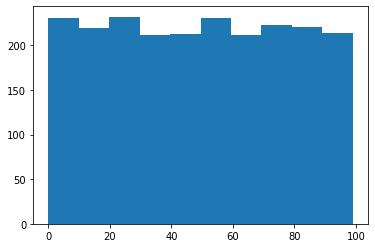

In [ ]:
plt.hist(campaigndf["Recency"])

(array([ 37., 185., 333., 399., 349., 366., 330., 174.,  28.,   3.]),
 array([  1730. ,  12930.4,  24130.8,  35331.2,  46531.6,  57732. ,
         68932.4,  80132.8,  91333.2, 102533.6, 113734. ]),
 <a list of 10 Patch objects>)

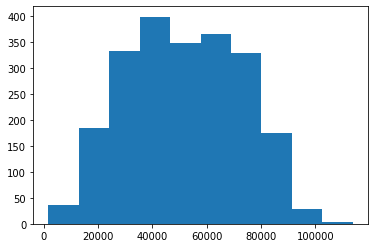

In [ ]:
plt.hist(campaigndf["Income"])

(array([217., 223., 197., 231., 220., 220., 214., 233., 213., 236.]),
 array([  0. ,  69.9, 139.8, 209.7, 279.6, 349.5, 419.4, 489.3, 559.2,
        629.1, 699. ]),
 <a list of 10 Patch objects>)

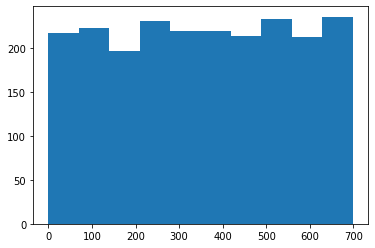

In [ ]:
plt.hist(campaigndf["Days_enrolled"])

from the above it seems only income follows a normal distribution, while the rest follows uniform distribution.

(array([445., 416., 340., 320., 251., 254., 273., 261., 242., 224.]),
 array([-1.70028863, -1.35762565, -1.01496267, -0.67229968, -0.3296367 ,
         0.01302629,  0.35568927,  0.69835225,  1.04101524,  1.38367822,
         1.72634121]),
 <a list of 10 Patch objects>)

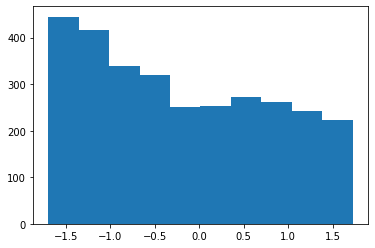

In [ ]:
plt.hist(new_trainx[:,0])

(array([216., 251., 225., 269., 256., 285., 326., 386., 390., 422.]),
 array([-1.76305351, -1.41471919, -1.06638488, -0.71805056, -0.36971625,
        -0.02138193,  0.32695238,  0.6752867 ,  1.02362101,  1.37195532,
         1.72028964]),
 <a list of 10 Patch objects>)

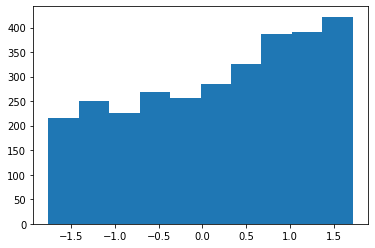

In [ ]:
plt.hist(new_trainx[:,1])

(array([ 41., 246., 413., 534., 420., 423., 471., 401.,  72.,   5.]),
 array([-2.37592131, -1.83700451, -1.29808772, -0.75917092, -0.22025413,
         0.31866267,  0.85757946,  1.39649626,  1.93541305,  2.47432984,
         3.01324664]),
 <a list of 10 Patch objects>)

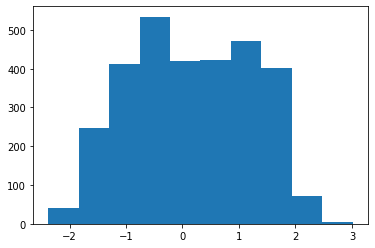

In [ ]:
plt.hist(new_trainx[:,2])

In [ ]:
# sns.kdeplot(new_trainx[:,0])
# sns.kdeplot(new_trainx[:,1])
# sns.kdeplot(new_trainx[:,2])

In [ ]:
ourdata = campaigndf[["Recency", "Income", "Days_enrolled", "Response"]]

In [ ]:
# with pm.Model() as logistic_model:
#     pm.glm.GLM.from_formula(
#         "Response ~ Recency + Income + Days_enrolled" , ourdata, family=pm.glm.families.Binomial()
#     )
#     trace = pm.sample(1000, tune=1000, init="adapt_diag")

In [ ]:
lower = -10
higher = 10
with pm.Model() as logistic_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_income=pm.Normal("beta_income", mu=0, sigma= 3)
    beta_recency=pm.Uniform('beta_recency', -3, 3)
    beta_days=pm.Uniform('beta_days', -3, 3)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_income*new_trainx[:,0]+ beta_recency*new_trainx[:,1]+beta_days*new_trainx[:,2]))

with logistic_model:
    #fit the data 
    observed=pm.Bernoulli("Response", p, observed=new_trainy)
    start=0
    step=pm.NUTS()
    #samples from posterior distribution 
    trace=pm.sample(2000,tune=1000 ,step=step, cores=4)
                               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_days, beta_recency, beta_income, beta_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.


In [ ]:
# with logistic_model:
#     az.plot_trace(trace)

In [ ]:
az.summary(trace, var_names=['beta_income', 'beta_recency', 'beta_days'])

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
beta_income  -0.778  0.046  -0.865   -0.694  ...      0.0    7426.0    6322.0    1.0
beta_recency  0.778  0.045   0.697    0.867  ...      0.0    8435.0    6381.0    1.0
beta_days     0.558  0.041   0.479    0.634  ...      0.0    8472.0    6170.0    1.0

[3 rows x 9 columns]

In [ ]:
clf.coef_

array([[-0.77559127,  0.77510991,  0.55647352]])

We can from above that betas returend by MCMC method almost matches the logistic regression betas calculated by traditional machine learning algorithm

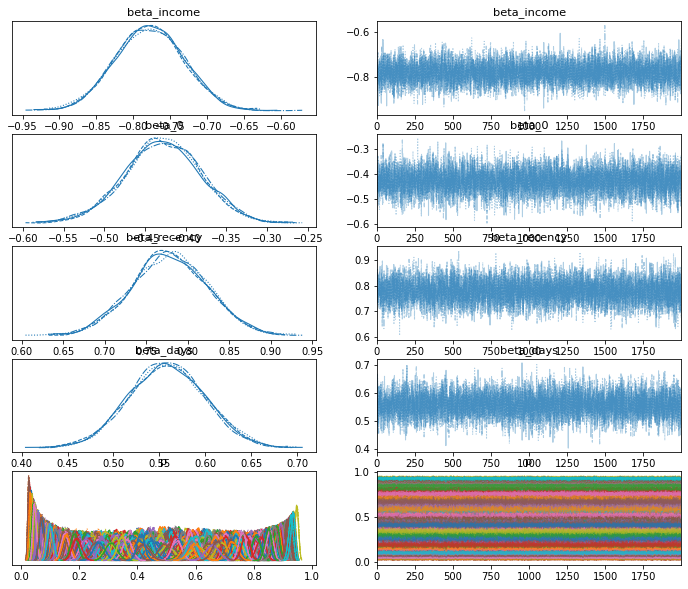

In [ ]:
with logistic_model:
    az.plot_trace(trace)

From the above chart we can see that the betas converge 

/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (3030) in plot_posterior, generating only 40 plots
  UserWarning,


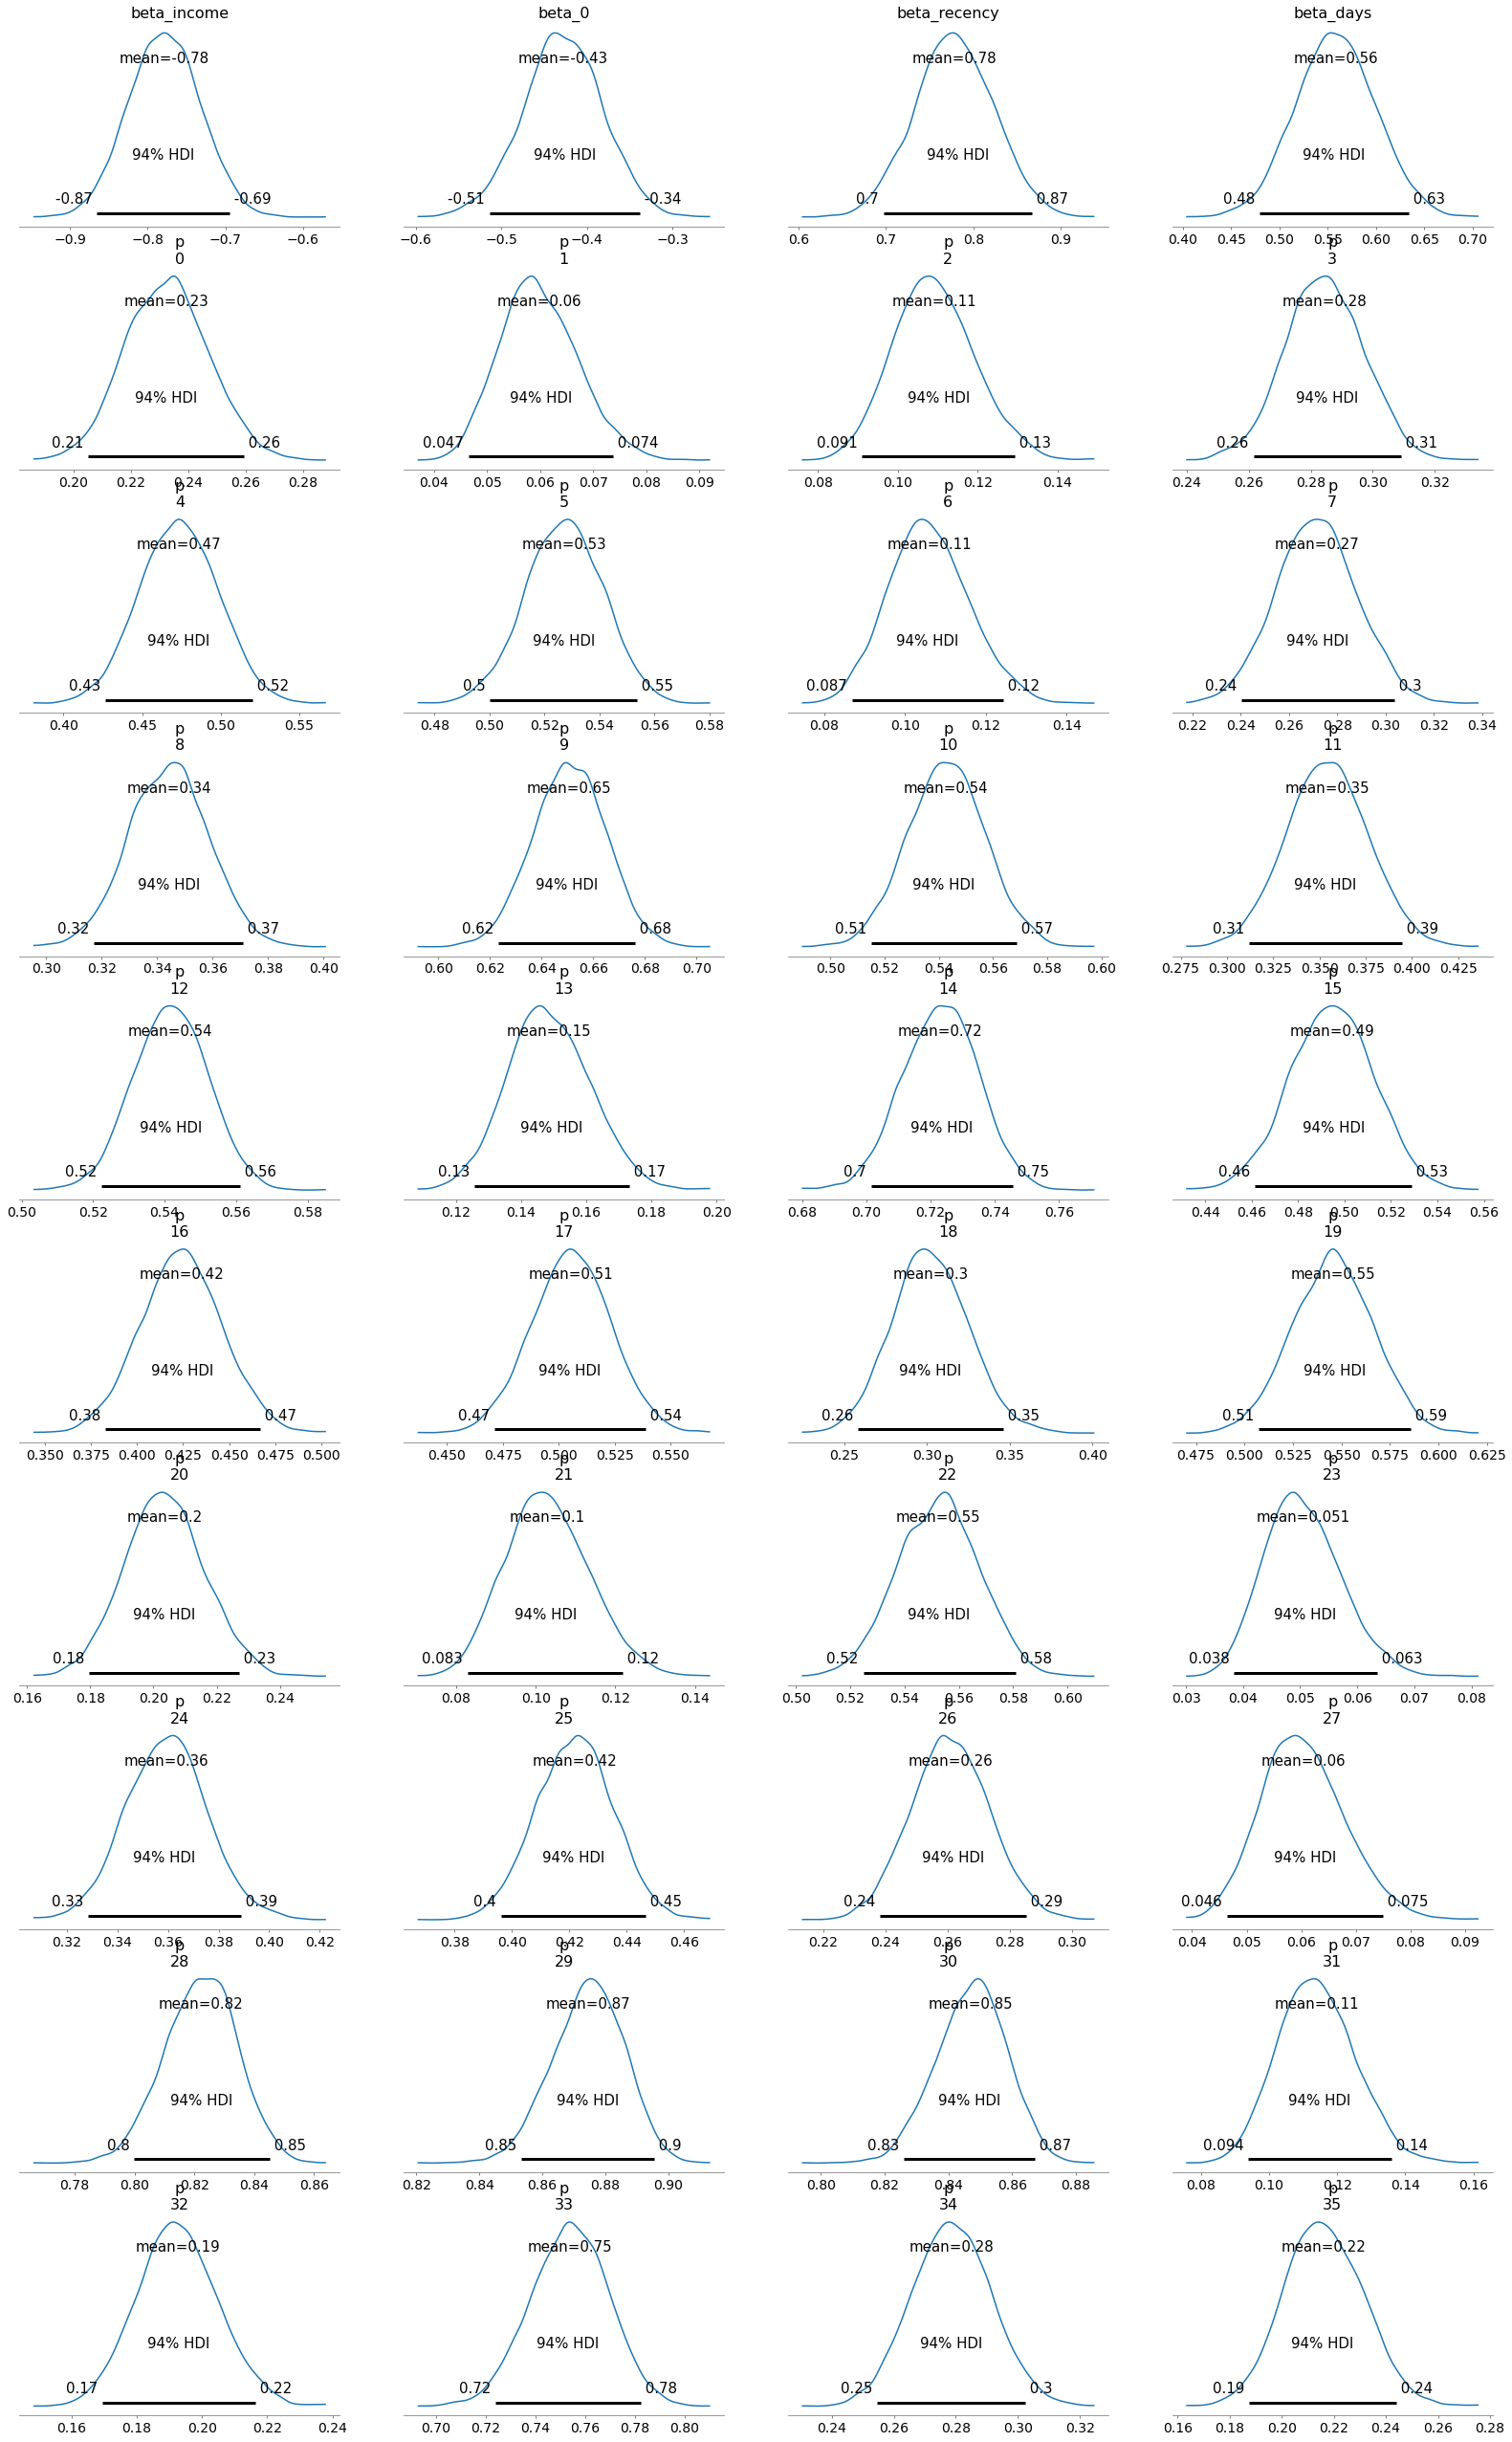

In [ ]:
with logistic_model:
    az.plot_posterior(trace)

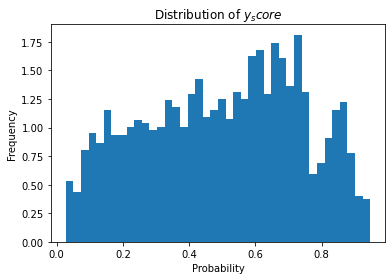

In [ ]:
#compute the average probability of predicting 1. 
y_score = np.mean(trace['p'], axis=0)
#histogram of the distribution
# figsize(12.5,4)
plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $y_score$')
plt.show()

It looks like our model is not as good in predicting as it looks to be spread out

In [ ]:
### sample from posterior distribution 
with logistic_model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=["beta_0", "beta_income", "beta_days", "beta_recency", "Response"])

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


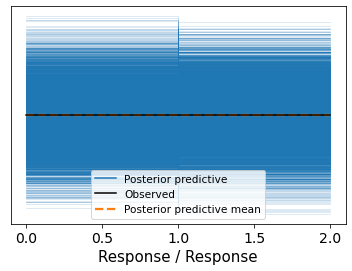

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=y_pred, model=logistic_model));

from the above also it shows that predictions are more spread out but suprisingly mean looks close to the observed